<a href="https://colab.research.google.com/github/kithmiGunawardna/Hate_Speech_detection/blob/master/Deep_learning_model_hate_speech_detection_using_pretrained_embadding_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade gensim

In [31]:
#import relevant libraraies
import pandas as pd
import numpy as np
from google.colab import drive

#imprtant libraris for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for deep learning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import string
from sklearn.utils import resample
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split

#word embading using pretrain model
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer

#RNN model
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

#validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



#hide warning
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 0 - hate speech 1 - offensive language 2 - neither

In [2]:
#import dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Campus_Research/labeled_data.csv')

Mounted at /content/drive


In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


**Cleaning the dataset**

In [4]:
#preprossesing part
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_mentions = tf.strings.regex_replace(stripped_html, r"@\w+", " ")
  stripped_hashtags = tf.strings.regex_replace(stripped_mentions, r"#\w+", " ")
  # Expand emoticons with appropriate library
  # stripped_emoticons = ...
  stripped_urls = tf.strings.regex_replace(stripped_hashtags, r"http(?s://)?\S+", " ")
  # Remove punctuation (existing logic)
  return tf.strings.regex_replace(stripped_urls, '[%s]' % re.escape(string.punctuation), '').numpy().decode('utf-8')

In [5]:
# Apply clean_text function
df.loc[:, 'tweet'] = df['tweet'].apply(custom_standardization)

In [6]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about c...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she ...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,yous a muthafin lie right his tl is tra...
24779,25292,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [7]:
df['tweet']

0         rt   as a woman you shouldnt complain about c...
1         rt   boy dats coldtyga dwn bad for cuffin dat...
2         rt   dawg rt   you ever fuck a bitch and she ...
3                            rt     she look like a tranny
4         rt   the shit you hear about me might be true...
                               ...                        
24778    yous a muthafin lie        right his tl is tra...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [8]:
df1 =df[['class', 'tweet']]
df1



,class,tweet
0,2,rt as a woman you shouldnt complain about c...
1,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,1,rt dawg rt you ever fuck a bitch and she ...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true...
...,...,...
24778,1,yous a muthafin lie right his tl is tra...
24779,2,youve gone and broke the wrong heart baby and ...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you lies


**Unbalanced data set**

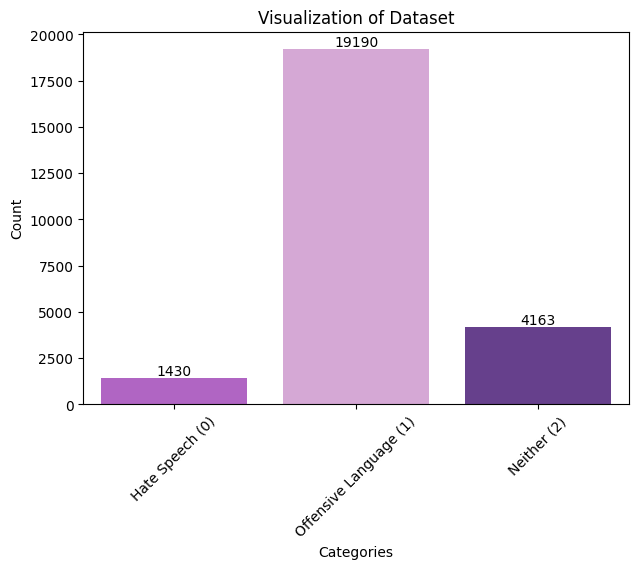

In [9]:
# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['mediumorchid', 'plum', 'rebeccapurple']  # Purple shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')





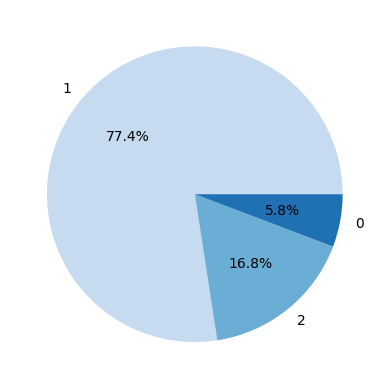

In [10]:
blue_palette = sns.color_palette("Blues", n_colors=3)  # Customize 'n_colors' based on the number of slices

# Create a pie chart with the blue color palette
plt.pie(
    df['class'].value_counts().values,  # Values for the pie chart
    labels=df['class'].value_counts().index,  # Labels for each slice
    autopct='%1.1f%%',  # Display the percentage with one decimal place
    colors=blue_palette  # Set the color palette to shades of blue
)

# Display the pie chart
plt.show()

In [11]:
y = df['class']
x = df.tweet

 **Balanced dataset using oversampling**

In [12]:
#create two different dataframe of majority and minority class
df_class_1 = df1[(df1['class']==1)]
df_class_2 = df1[(df1['class']==2)]
df_class_0 = df1[(df1['class']==0)]
# undersample class_1 class
df_class_2_oversampled = resample(df_class_2,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# undersample class_1 class
df_class_0_oversampled = resample(df_class_0,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
oversampled_df  = pd.concat([df_class_2_oversampled, df_class_0_oversampled,df_class_1])

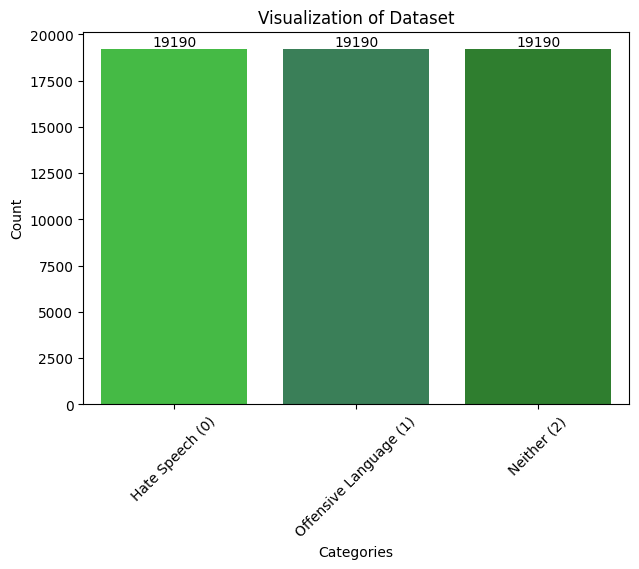

In [13]:

# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = oversampled_df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['limegreen', 'seagreen', 'forestgreen']  # green shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')

In [14]:
oversampled_df

,class,tweet
5073,2,nope super chocolatey yummy brownies
22172,2,thou shall not mock ryanthe futurekelly
18219,2,rt my trash is worth more than you
2869,2,penske runs the 22 in nascar its yellow ther...
20198,2,rt a birds eye view of todays activities t...
...,...,...
24774,1,you really care bout dis bitch my dick all in ...
24775,1,you worried bout other bitches you need me for
24778,1,yous a muthafin lie right his tl is tra...
24780,1,young buck wanna eat dat nigguh like i aint fu...


**Tokanization**

In [15]:
oversampled_df['tweet'] = oversampled_df['tweet'].astype(str)

# Apply word tokenization, ensuring the results are list of tokens
oversampled_df['tweet_tokanized'] = oversampled_df['tweet'].apply(lambda text: word_tokenize(text))

# Display the DataFrame with the tokenized column


In [16]:
oversampled_df

,class,tweet,tweet_tokanized
5073,2,nope super chocolatey yummy brownies,"[nope, super, chocolatey, yummy, brownies]"
22172,2,thou shall not mock ryanthe futurekelly,"[thou, shall, not, mock, ryanthe, futurekelly]"
18219,2,rt my trash is worth more than you,"[rt, my, trash, is, worth, more, than, you]"
2869,2,penske runs the 22 in nascar its yellow ther...,"[penske, runs, the, 22, in, nascar, its, yello..."
20198,2,rt a birds eye view of todays activities t...,"[rt, a, birds, eye, view, of, todays, activiti..."
...,...,...,...
24774,1,you really care bout dis bitch my dick all in ...,"[you, really, care, bout, dis, bitch, my, dick..."
24775,1,you worried bout other bitches you need me for,"[you, worried, bout, other, bitches, you, need..."
24778,1,yous a muthafin lie right his tl is tra...,"[yous, a, muthafin, lie, right, his, tl, is, t..."
24780,1,young buck wanna eat dat nigguh like i aint fu...,"[young, buck, wan, na, eat, dat, nigguh, like,..."


In [17]:
oversampled_df1 = oversampled_df.copy(deep=True)

**word embading using pre trained model**

**word2Vec**

In [18]:
# Train the model
model = Word2Vec(oversampled_df['tweet_tokanized'], min_count=1,sg=1)

# Summarize the loaded model
print("Model Summary:")
print(model)

# Summarize the vocabulary
words = list(model.wv.key_to_index.keys())
print("Vocabulary:")
print(words)

# Access vector for a specific word
vector = model.wv['hello']  # Access vector for a specific word
print("Vector for 'hello':")
print(vector)

# Save the model to a binary file
model.save('word2vec_model.bin')

# Load the model from the binary file
new_model = Word2Vec.load('word2vec_model.bin')

# Confirm loaded model has the same vocabulary
print("Loaded Model Summary:")
print(new_model)

# Check if specific word vectors are the same after reloading
vector_reloaded = new_model.wv['hello']
print("Vector for 'hello' after reloading:")
print(vector_reloaded)

# Test for equality to ensure reloading works
is_equal = (vector == vector_reloaded).all()  # Check if original and reloaded vectors are the same
print("Vectors are equal after reloading:", is_equal)


Model Summary:
Word2Vec<vocab=20650, vector_size=100, alpha=0.025>
Vocabulary:
['a', 'the', 'rt', 'i', 'you', 'to', 'bitch', 'and', 'is', 'in', 'that', 'of', 'my', 'like', 'on', 'me', 'be', 'trash', 'for', 'this', 'it', 'im', 'with', 'bitches', 'your', 'are', 'dont', 'all', 'just', 'so', 'they', 'ass', 'if', 'up', 'hoes', 'but', 'nigga', 'fuck', 'u', 'got', 'get', 'pussy', 'not', 'at', 'faggot', 'no', 'when', 'have', 'was', 'hoe', 'he', 'these', 'out', 'its', 'lol', 'white', 'can', 'amp', 'shit', 'what', 'do', 'about', 'we', 'she', 'fucking', 'some', 'niggas', 'who', 'them', 'aint', 'or', 'her', 'as', 'one', 'youre', 'know', 'his', 'how', 'nigger', 'from', 'go', 'bird', 'people', 'love', 'now', 'hate', 'an', 'want', 'cant', 'man', 'charlie', 'look', 'then', 'na', 'good', 'yall', 'why', 'will', 'thats', 'fag', 'only', 'think', 'say', 'yellow', 'see', 'off', 'too', 'really', 'still', 'make', 'yo', 'their', 'time', 'would', 'by', 'here', 'back', 'more', 'because', 'day', 'black', 'even', 

**Golve**

In [ ]:
#filepath = 'glove.6B.50d.txt'



In [ ]:
# tokenizer = Tokenizer(num_words=23370)
# tokenizer.fit_on_texts(oversampled_df1['tweet_tokanized'])

# # Create a word index
# word_index = tokenizer.word_index

# # Function to create an embedding matrix
# def embedding_for_vocab(filepath, word_index, embedding_dim):
#     vocab_size = len(word_index) + 1  # Plus one for reserved padding index
#     embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize embedding matrix

#     with open(filepath, 'r', encoding="utf8") as f:
#         for line in f:
#             parts = line.split()  # Split line into word and its vector
#             word = parts[0]  # First part is the word
#             vector = np.array(parts[1:], dtype=np.float32)  # The rest is the embedding vector
#             if word in word_index:
#                 idx = word_index[word]  # Get index from word index
#                 embedding_matrix[idx] = vector  # Insert the embedding vector into matrix

#     return embedding_matrix

# # Define embedding dimension and create embedding matrix
# embedding_dim = 50  # The dimension of GloVe embeddings you're using
# embedding_matrix = embedding_for_vocab('glove.6B.50d.txt', word_index, embedding_dim)

# # Example output
# print("Dense vector for the first word (with index 1) is:", embedding_matrix[1])
# embedding_matrix = embedding_for_vocab(filepath, word_index, 50)

**Train Test split**

In [19]:
def tokens_to_indices(word2vec_model, tokens, max_len):
    indices = []
    for token in tokens:
        if token in word2vec_model.wv.key_to_index:
            indices.append(word2vec_model.wv.key_to_index[token])
        else:
            indices.append(0)  # Use a special index for unknown words
    return indices

In [20]:
X_indices = [tokens_to_indices(new_model, tokens, 35) for tokens in oversampled_df['tweet_tokanized']]
X_padded = pad_sequences(X_indices, maxlen=35, padding='post')  # Pad sequences to the same length


In [43]:
y = oversampled_df['class']
x =X_padded

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**RNN Model**

In [45]:


# Load your pre-trained Word2Vec model
word2vec_model = Word2Vec.load('word2vec_model.bin')

# Get the vocabulary size and embedding dimension
vocab_size = len(word2vec_model.wv)  # Get the vocabulary size from Word2Vec
embedding_dim = word2vec_model.vector_size  # Get the embedding dimension from Word2Vec
sequence_length = 35  # Example input sequence length (you may adjust it)

# Create the embedding matrix using Word2Vec model
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Create an empty embedding matrix
# Fill the embedding matrix with the pre-trained Word2Vec vectors
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_matrix[i] = word2vec_model.wv[word]

# Create the Keras model
model = Sequential(name='simple_RNN')
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=sequence_length,
        trainable=False  # Set to True if you want to fine-tune the embeddings
    )
)
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 100)           2065000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 35, 64)            10560     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2092265 (7.98 MB)
Trainable params: 27265 

In [46]:
model.compile("rmsprop",
              "binary_crossentropy",
              metrics=["accuracy"])


In [47]:
# Define EarlyStopping with a desired metric and patience level
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop after 3 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    mode='min'  # 'min' to minimize the monitored metric (loss)
)


In [48]:
#have to put the model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,  # Maximum number of epochs
    batch_size=32,  # Adjust based on your GPU capacity
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)

Epoch 1/10
1440/1440 [==============================] - 38s 25ms/step - loss: 0.0289 - accuracy: 0.3325 - val_loss: -0.0436 - val_accuracy: 0.3366
Epoch 2/10
1440/1440 [==============================] - 28s 20ms/step - loss: 0.0350 - accuracy: 0.3325 - val_loss: -0.0408 - val_accuracy: 0.3366
Epoch 3/10
1440/1440 [==============================] - 29s 20ms/step - loss: 0.0224 - accuracy: 0.3325 - val_loss: -0.0382 - val_accuracy: 0.3366
Epoch 4/10
1440/1440 [==============================] - 29s 20ms/step - loss: 0.0282 - accuracy: 0.3325 - val_loss: -0.0371 - val_accuracy: 0.3366


**Validation**

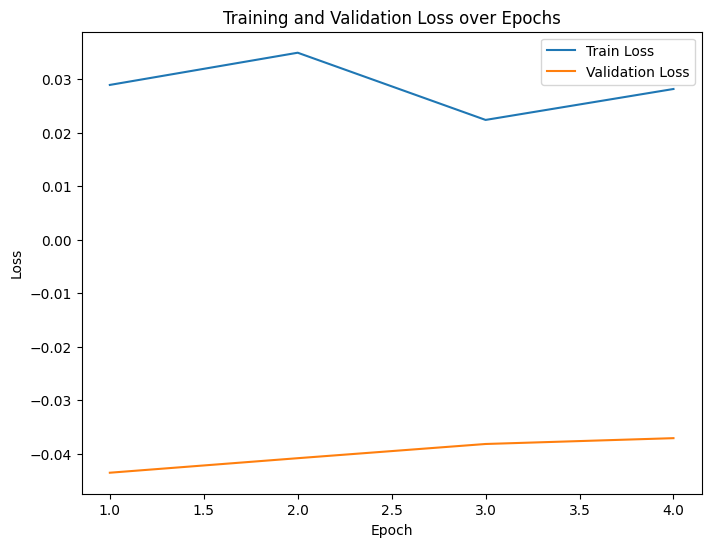

In [49]:
epochs = list(range(1, len(history.history['loss']) + 1))  # Create a list of epochs

# Create a DataFrame for Seaborn
import pandas as pd

# Combine training and validation loss into a DataFrame
Simple_RNN_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
})

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Validation Loss', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

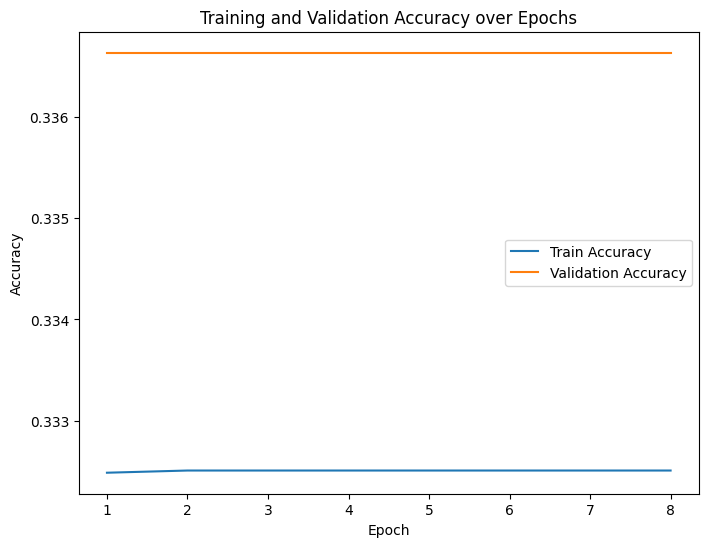

In [34]:
epochs = list(range(1, len(history.history['accuracy']) + 1))

# Create a DataFrame for training and validation accuracy
accuracy_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
})

# Plot the training and validation accuracy with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='Epoch', y='Train Accuracy', label='Train Accuracy')
sns.lineplot(data=accuracy_df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
# Get the predictions from the model
# We need to round them to get binary outcomes since the final activation is sigmoid
y_pred= model.predict(x_test)  # Get raw predictions


# Calculate accuracy, F1-score, recall, and precision
accuracy = accuracy_score(np.argmax(y_test), np.argmax(y_pred))  # Calculate accuracy
f1 = f1_score(np.argmax(y_test,axis=1), np.argmax(y_pred))  # Calculate F1-score
recall = recall_score(np.argmax(y_test,axis=1), np.argmax(y_pred))  # Calculate recall
precision = precision_score(np.argmax(y_test,axis=1), np.argmax(y_pred))  # Calculate precision

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

360/360 [==============================] - 5s 11ms/step


InvalidParameterError: The 'y_true' parameter of accuracy_score must be an array-like or a sparse matrix. Got 3 instead.

In [52]:
cm_simple_RNN= confusion_matrix(np.argmax(y_test), np.argmax(y_pred))
sns.heatmap(data=cm_simple_RNN, annot=True)

TypeError: Singleton array 3 cannot be considered a valid collection.

In [53]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),labels=[0,1,2]))

ValueError: `axis` must be fewer than the number of dimensions (1)

In [ ]:
new_array = [["you bitch"],["your're very good"],["you damn girl"]]
lables =['hate speech','offensive language','neither']

In [ ]:
for message in new_array:
  X = tokenizer.texts_to_sequences(message)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  output=model.predict(X)
  print(output,lables[np.argmax(output)],message,"\n")
